In [118]:
import pandas as pd
import numpy as np

In [119]:
import torch

In [120]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

In [121]:
df1 = pd.read_csv("data/spotify52kData.csv")

### Q1: Is there a relationship between song length and popularity of a song? If so, is it positive or negative?

In [136]:
print(df1['popularity'].isnull().sum(), df1['duration'].isnull().sum())
#no null values, no imputation or dropping rows needed

0 0


In [137]:
duration_vals = np.asarray(df1['duration'])
popularity_vals = np.asarray(df1['popularity'])

Text(0.5, 1.0, 'histogram for popularity of a song')

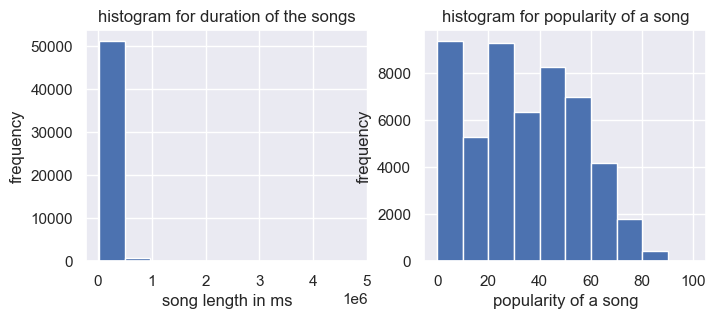

In [140]:
#plot histogram for duration
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.hist(duration_vals)
plt.xlabel("song length in ms")
plt.ylabel("frequency")
plt.title('histogram for duration of the songs')
# Plotting histogram of popularity
plt.subplot(1,2,2)
plt.hist(popularity_vals)
plt.xlabel("popularity of a song")
plt.ylabel("frequency")
plt.title('histogram for popularity of a song')

In [141]:
#test skewness and found the duration data is highly, positively skewed
from scipy.stats import skew, normaltest
print(normaltest(duration_vals),normaltest(popularity_vals))

NormaltestResult(statistic=89338.51687708273, pvalue=0.0) NormaltestResult(statistic=7965.592889275917, pvalue=0.0)


In [130]:
#transform the data via natural log transformation to normalize it
#so that we meet assumption for PearsonR test
duration_logged = np.log(duration_vals)
skew(duration_logged)

-0.3907430152266713

Text(0.5, 1.0, 'duration of songs after log transformation')

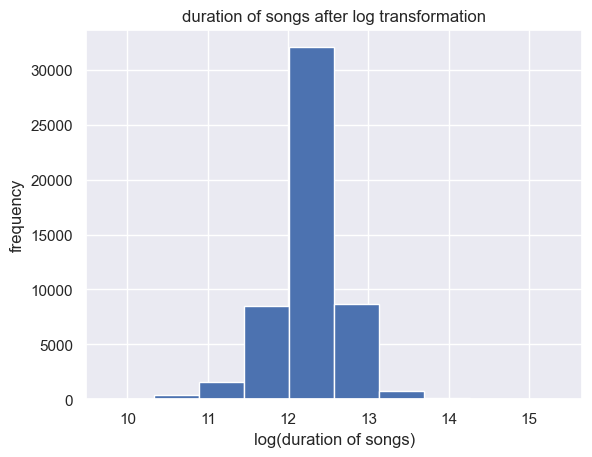

In [131]:
#histogram for duration of songs after natural log transformation
f, ax = plt.subplots()
ax.hist(duration_logged)
ax.set_xlabel("log(duration of songs)")
ax.set_ylabel("frequency")
ax.set_title("duration of songs after log transformation")

NormaltestResult(statistic=array([151995.45189202]), pvalue=array([0.]))
NormaltestResult(statistic=array([28545.00974066]), pvalue=array([0.]))


/var/folders/76/3s8ndvb92wb2y403vv_58mkh0000gn/T/ipykernel_80401/2774584098.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_hat = float(reg1.coef_)*x+ + reg1.intercept_


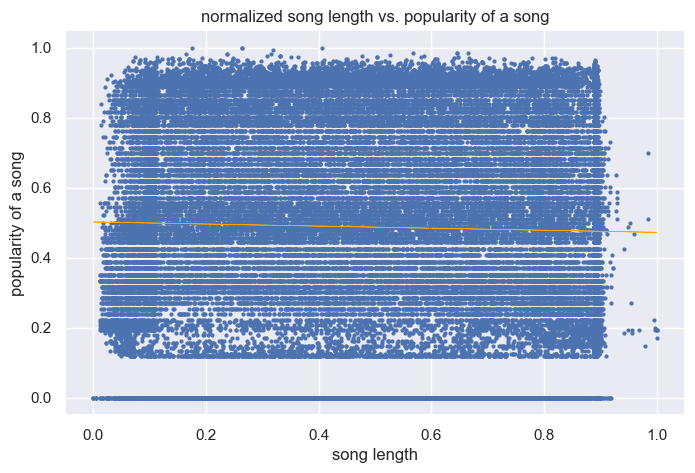

R^2: 0.001
RMSE: 67.032


In [160]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(n_quantiles=10, random_state=0)
duration_exp = duration_vals.reshape(-1,1)
transformed_duration = qt.fit_transform(duration_exp)
print(normaltest(transformed_duration))
x = transformed_duration.reshape(-1,)
popularity_exp = popularity_vals.reshape(-1,1)
transformed_popularity = qt.fit_transform(popularity_exp)
print(normaltest(transformed_popularity))
y = transformed_popularity.reshape(-1,)
reg1 = LinearRegression()
reg1.fit(transformed_duration,y)
y_hat = float(reg1.coef_)*x+ + reg1.intercept_
plt.figure(figsize=(8,5))
plt.plot(x, y, 'o', ms=2)
plt.plot(x, y_hat, color='orange', linewidth=0.5) # orange line for the fox
plt.xlabel("song length")
plt.ylabel("popularity of a song")
plt.title("normalized song length vs. popularity of a song")
plt.show()
r2 = r2_score(y,y_hat)
print('R^2:', r2.round(3))
rmse = np.sqrt(np.mean(np.sum((y-y_hat)**2)))
print('RMSE:', rmse.round(3))

In [161]:
from scipy.stats.stats import pearsonr
pearsonr(x,y)

/var/folders/76/3s8ndvb92wb2y403vv_58mkh0000gn/T/ipykernel_80401/1894363853.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


PearsonRResult(statistic=-0.027552223247932828, pvalue=3.301504702929647e-10)

### Q4: Which of the following 10 song features: duration, danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence and tempo predicts popularity best? How good is this model?

In [183]:
column_list = ['duration', 'danceability', 'energy', 'loudness', 'speechiness','acousticness', 'instrumentalness', 'liveness',
                'valence','tempo']
cols_dict = {}

In [184]:
#we do not transform data to reduce skewness for this question
#because this kind of transformation may reduce R^2 for certain columns
from sklearn.model_selection import cross_val_score, KFold
from scipy import stats
random_seed = 14276662
column = np.asarray(df1['duration'])
skewness1 = stats.skew(column)
logged_col = np.log(column)
skewness2 = stats.skew(logged_col)
col_exp = column.reshape(-1,1)
logged_exp = logged_col.reshape(-1,1)
reg = LinearRegression()
x = col_exp
x_logged = logged_exp
y = popularity_vals
kfold=KFold(n_splits=10,shuffle = True, random_state = random_seed)
scores = cross_val_score(reg,x,y,cv=kfold,scoring='r2').mean()
scores_for_logged = cross_val_score(reg,x_logged,y,cv=kfold,scoring='r2').mean()
print("skewness reduced from",skewness1,"to",skewness2,"while mean of R^2 dropped from",scores, "to",scores_for_logged)

skewness reduced from 11.56503934705492 to -0.3907430152266713 while mean of R^2 dropped from 0.0027683257445593745 to 0.0001215348581612763


In [185]:
def simple_linear(column_name: str):
    column = np.asarray(df1[column_name])
    col_exp = column.reshape(-1,1)
    reg = LinearRegression()
    x = col_exp
    y = popularity_vals
    kfold=KFold(n_splits=10,shuffle = True, random_state = random_seed)
    scores = cross_val_score(reg,x,y,cv=kfold,scoring='r2')
    cols_dict[column_name] = scores.mean()

In [186]:
for i in column_list:
    simple_linear(i)

In [188]:
relevance = sorted(cols_dict.items(),key = lambda x:x[1], reverse=True)
sorted_list = [[i[0],i[1]] for i in relevance]
sorted_list

[['instrumentalness', 0.02078874135752413],
 ['loudness', 0.0034019277308734775],
 ['energy', 0.002915083895579629],
 ['duration', 0.0027683257445593745],
 ['speechiness', 0.002133281425316336],
 ['liveness', 0.001677915314502987],
 ['danceability', 0.0011216160807649867],
 ['valence', 0.000977688415243716],
 ['acousticness', 0.0004707880946256293],
 ['tempo', -0.0002458812831519053]]

In [189]:
table_q4 = pd.DataFrame(sorted_list,columns=['song feature','average COD via 10-fold'])
table_q4

,song feature,average COD via 10-fold
0,instrumentalness,0.020789
1,loudness,0.003402
2,energy,0.002915
3,duration,0.002768
4,speechiness,0.002133
5,liveness,0.001678
6,danceability,0.001122
7,valence,0.000978
8,acousticness,0.000471
9,tempo,-0.000246


### Q5: Building a model that uses *all* of the song features mentioned in question 4, how well can you predict popularity? How much (if at all) is this model improved compared to the model in question 4). How do you account for this? What happens if you regularize your model?

In [205]:
temp_list = []
for i in column_list:
    temp_list.append(np.asarray(df1[i]).reshape(-1,1))
tuple_ten = tuple(temp_list)
x = np.concatenate(tuple_ten, axis=1)
y = popularity_vals
reg = LinearRegression()
kfold=KFold(n_splits=10,shuffle = True, random_state = random_seed)
scores = cross_val_score(reg,x,y,cv=kfold,scoring='r2')
multi_score = scores.mean()
multi_score

0.04715423740665784

In [206]:
diff = multi_score - sorted_list[0][1]
diff_percent = diff*100/sorted_list[0][1]
print("compared to the best model in question 4, the R^2 increased by",str(diff.round(3))+',','achieving a',str(diff_percent.round(2))+'%',"improvement")

compared to the best model in question 4, the R^2 increased by 0.026, achieving a 126.83% improvement


In [207]:
from sklearn.linear_model import Ridge
alphas=np.arange(0,10,0.5)
best = [0,multi_score]
alpha_dict = {}
for alpha in alphas:
    ridge = Ridge(alpha = alpha)
    kfold=KFold(n_splits=10,shuffle = True, random_state = random_seed)
    scores = cross_val_score(ridge, x, y, cv=kfold, scoring = 'r2')
    now_score = scores.mean() 
    alpha_dict[alpha] = now_score
    if scores.mean()>best[1]:
        best = [alpha, scores.mean()]
best

[6.5, 0.047154778196946315]

In [208]:
relevance = sorted(alpha_dict.items(),key = lambda x:x[1], reverse=True)
sorted_list = [[i[0],i[1]-multi_score] for i in relevance]
table_q4 = pd.DataFrame(sorted_list,columns=['alpha','improvement of R^2'])
table_q4

,alpha,improvement of R^2
0,6.5,5.407903e-07
1,6.0,5.393709e-07
2,7.0,5.356040e-07
3,5.5,5.313266e-07
4,7.5,5.238313e-07
5,5.0,5.166380e-07
6,8.0,5.054914e-07
7,4.5,4.952856e-07
8,8.5,4.806034e-07
9,4.0,4.672498e-07


In [209]:
((best[1]-multi_score)/multi_score)*100

0.001146854064906281

In [210]:
best[1]-multi_score

5.407902884738136e-07

In [213]:
from sklearn.linear_model import Lasso
alphas=np.arange(0,10,0.5)
best = [0,multi_score]
alpha_dict = {}
for alpha in alphas:
    lasso = Lasso(alpha = alpha)
    kfold=KFold(n_splits=10,shuffle = True, random_state = random_seed)
    scores = cross_val_score(lasso, x, y, cv=kfold, scoring = 'r2')
    now_score = scores.mean() 
    alpha_dict[alpha] = now_score
    if scores.mean()>best[1]:
        best = [alpha, scores.mean()]
print(best)

/Users/erchizhang/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/base.py:1151: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/erchizhang/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/erchizhang/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.053e+07, tolerance: 2.212e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.li

[0.0, 0.04715423740665786]


In [215]:
relevance = sorted(alpha_dict.items(),key = lambda x:x[1], reverse=True)
sorted_list = [[i[0],i[1]-multi_score] for i in relevance]
table_q4 = pd.DataFrame(sorted_list,columns=['alpha','improvement of R^2'])
table_q4

,alpha,improvement of R^2
0,0.0,2.081668e-17
1,0.5,-3.044043e-02
2,1.0,-4.065952e-02
3,1.5,-4.078392e-02
4,2.0,-4.095830e-02
5,2.5,-4.118265e-02
6,3.0,-4.145094e-02
7,3.5,-4.175355e-02
8,4.0,-4.207960e-02
9,4.5,-4.244840e-02


### Q6:When considering the 10 song features in the previous question, how many meaningful principal components can you extract? What proportion of the variance do these principal components account for? Using these principal components, how many clusters can you identify? Do these clusters reasonably correspond to the genre labels in column 20 of the data?

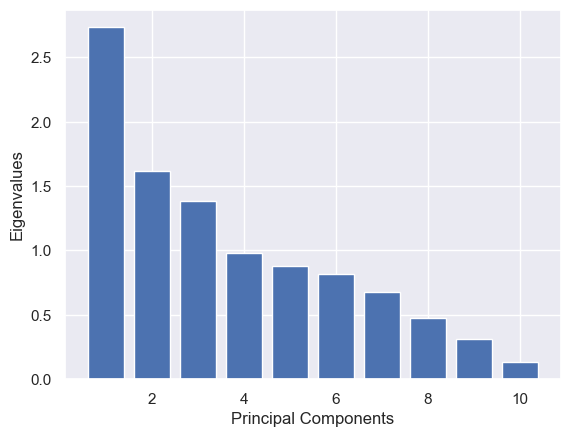

Proportion variance explained by the first 5 PCs: 0.759


In [337]:
from sklearn.decomposition import PCA
# Z-score the data:
zscoredData = stats.zscore(x)

# Initialize PCA object and fit to our data:
pca = PCA().fit(zscoredData)

# Eigenvalues: Single vector of eigenvalues in decreasing order of magnitude
eigVals = pca.explained_variance_

# Rotated Data - simply the transformed data:
#origDataNewCoordinates = pca.fit_transform(zscoredData)*-1
numPredictors = np.size(x,axis=1)
plt.bar(np.linspace(1,numPredictors,numPredictors),eigVals)
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalues')
plt.show()
print('Proportion variance explained by the first 5 PCs:',np.sum(eigVals[:5]/np.sum(eigVals)).round(3))

In [338]:
PCA_dict = {}
for i in range(1,11):
    PCA_dict[i]=np.sum(eigVals[:i]/np.sum(eigVals))
PCA_list = [[i,PCA_dict[i]] for i in PCA_dict]
table_q5 = pd.DataFrame(PCA_list,columns=['top n meaningful principal components','cumulative porportion of variance explained'])
table_q5.style.hide()
    

top n meaningful principal components,cumulative porportion of variance explained
1,0.273388
2,0.435124
3,0.573582
4,0.671541
5,0.759062
6,0.840545
7,0.908372
8,0.955529
9,0.986842
10,1.000000


In [339]:
transformed = PCA(n_components=5).fit_transform(zscoredData)

In [228]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm import tqdm
numClusters = 24 # loop over different # of clusters (2 to 25)
Q = np.empty([numClusters,1])*np.NaN # init container to store sums
# Compute kMeans:
for ii in tqdm(range(2, 2+numClusters)): 
    kMeans = KMeans(n_clusters = int(ii)).fit(transformed) # compute kmeans using scikit
    cId = kMeans.labels_ # vector of cluster IDs that the row belongs to
    cCoords = kMeans.cluster_centers_ # coordinate location for center of each cluster
    s = silhouette_samples(transformed,cId) # compute the mean silhouette coefficient of all samples
    Q[ii-2] = sum(s) # take the sum

  0%|          | 0/24 [00:00<?, ?it/s]/Users/erchizhang/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
  4%|▍         | 1/24 [00:34<13:22, 34.90s/it]/Users/erchizhang/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
  8%|▊         | 2/24 [01:07<12:16, 33.49s/it]/Users/erchizhang/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X

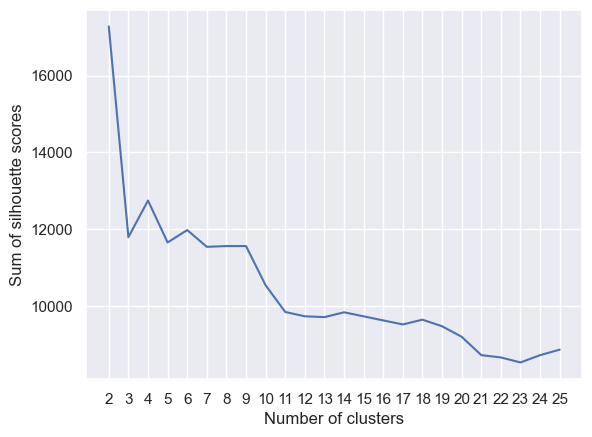

In [237]:
plt.plot(np.arange(2,26,1),Q)
plt.xticks(np.arange(2,26,1))
plt.xlabel('Number of clusters')
plt.ylabel('Sum of silhouette scores')
plt.show()

In [238]:
transformed.shape

(52000, 5)

In [258]:
kmeans = KMeans(n_clusters = 2, random_state = random_seed).fit(transformed)
labels_kmeans = kmeans.labels_
labels_kmeans

/Users/erchizhang/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([1, 0, 0, ..., 1, 1, 1], dtype=int32)

In [282]:
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
genres = LE.fit_transform(df1['track_genre'])
np.unique(genres)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51])

In [287]:
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
cluster_zero = np.asarray(labels_kmeans==0).nonzero()[0]
cluster_one = np.asarray(labels_kmeans==1).nonzero()[0]
fit_zero = np.zeros(52)
fit_one = np.zeros(52)
for i in cluster_zero:
    fit_index = genres[i]
    fit_zero[fit_index]+=1
for i in cluster_one:
    fit_index = genres[i]
    fit_one[fit_index]+=1
fit_zero = fit_zero*np.sum(fit_one)/np.sum(fit_zero)
fit_zero

array([2274.10421693,  454.01727299,  241.0711184 ,  321.42815787,
       3608.03107208, 1040.6236611 ,  188.83904275, 1566.96226961,
       1036.60580913,  638.83846377,   28.12496381, 1791.96198012,
       2020.9795426 ,  156.69622696, 1458.48026633, 2157.5865097 ,
       3740.6201872 ,  449.99942102, 1261.60551964,  863.83817427,
         48.21422368,   76.33918749,   28.12496381,  148.66052301,
        626.78490785,  341.51741774, 3105.79957541,   16.07140789,
        172.76763485,  148.66052301,   12.05355592,  401.78519734,
        550.44572035,  454.01727299, 1554.90871369,   36.16066776,
        984.37373347,  313.39245392,  498.2136447 , 1510.71234199,
        843.74891441,  389.73164142,   76.33918749,  273.21393419,
        124.55341117, 3154.01379909,   24.10711184,  180.8033388 ,
         36.16066776,    0.        ,   68.30348355,  136.60696709])

In [288]:
chisquare(fit_zero,fit_one)

Power_divergenceResult(statistic=440200.9978634822, pvalue=0.0)

### Q8:Can you predict genre by using the 10 song features from question 4 directly or the principal components you extracted in question 6 with a neural network? How well does this work?

In [348]:
import math

class Module(object):
    """
    Base class defining the structure and interface for neural network modules 
    with placeholders for forward and backward computations.
    """
    def __init__(self):
        self.gradInput=None # stores gradient
        self.output=None # stores loss
        
    def forward(self, *input):
        """
        Placeholder for forward pass. Defines the computation performed at every call.
        Enforces that subclasses must implement their own version of the forward method
        """
        raise NotImplementedError
        
    def backward(self, *input):
        """
        Placeholder for backward pass. Defines the computation performed at every call.
        Enforces that subclasses must implement their own version of the backward method
        """
        raise NotImplementedError
        
        
class LeastSquareCriterion(Module):
    """
    This implementation of the least square loss assumes that the data comes as a 2 dimensional array
    of size (batch_size,num_classes) and the labels as a vector of size (num_classes) 
    """
    def __init__(self, num_classes=52):
        super(LeastSquareCriterion, self).__init__()
        self.num_classes=num_classes
    
    def forward(self, x, labels):
        target=np.zeros([x.shape[0],self.num_classes])
        for i in range(x.shape[0]):
            target[i,labels[i]]=1
        self.output = np.sum((target-x)**2,axis=0)
        return np.sum(self.output)
    
    def backward(self, x, labels):
        self.gradInput=x
        for i in range(x.shape[0]):
            self.gradInput[i,labels[i]]=x[i,labels[i]]-1 # gradient of loss
        return self.gradInput
    

class Linear(Module):
    """
    The input is supposed to have two dimensions (batchSize, in_feature)
    """
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features # dimensions
        self.out_features = out_features # dimensions
        np.random.seed(random_seed)
        self.weight = math.sqrt(1. / (out_features* in_features))*np.random.randn(out_features, in_features)
        self.bias = np.zeros(out_features)
        self.gradWeight=None
        self.gradBias=None
        
    def forward(self, x): # this is our linear unit
        self.output= np.dot(x,self.weight.transpose())+np.repeat(self.bias.reshape([1,-1]),x.shape[0], axis=0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput=np.dot(gradOutput,self.weight)
        self.gradWeight=np.dot(gradOutput.transpose(),x)
        self.gradBias=np.sum(gradOutput, axis=0)
        return self.gradInput
    
    def gradientStep(self, lr):
        self.weight=self.weight-lr*self.gradWeight
        self.bias=self.bias-lr*self.gradBias
        

class ReLU(Module):
    """
    Implement the Rectified Linear Unit activation function for introducing non-linearity in the network.
    """
    
    def __init__(self, bias=True):
        super(ReLU, self).__init__()
        
    def forward(self, x):
        self.output=x.clip(0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput=(x>0)*gradOutput
        return self.gradInput
    

class MLP(Module):
    """
    simple neural network architecture with two linear layers and a ReLU activation function in between.
    """

    def __init__(self, num_features = 10,num_classes=52):
        super(MLP, self).__init__()
        self.fc1 = Linear(num_features, 64)
        self.relu1 = ReLU()
        self.fc2 = Linear(64, num_classes)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x) # notice: no relu on the final output
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc2.backward(self.relu1.output,gradient)
        gradient = self.relu1.backward(self.fc1.output,gradient)
        gradient = self.fc1.backward(x,gradient)
        return gradient
    
    def gradientStep(self, lr):
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)
        return True

In [349]:
def train_model(num_epochs, learn_rate, batch_size, model, criterion, train_data, train_labels, val_data, val_labels):
    
    n_train, n_val = len(train_data), len(val_data)
    train_loss = np.empty([num_epochs, int(n_train/batch_size)])
    val_loss = np.empty([num_epochs, int(n_val/batch_size)])
    
    for epoch in range(num_epochs):
        
        # Training loop
        for i in range(int(n_train/batch_size)):
            x = train_data[batch_size*i:batch_size*(i+1)]
            y = train_labels[batch_size*i:batch_size*(i+1)]
            y_pred = model.forward(x)
            train_loss[epoch, i] = criterion.forward(y_pred, y)
            grad0 = criterion.backward(y_pred, y)
            grad = model.backward(x, grad0)
            model.gradientStep(learn_rate)  

        # Validation loop
        for j in range(int(n_val/batch_size)):
            x = val_data[batch_size*j:batch_size*(j+1)]
            y = val_labels[batch_size*j:batch_size*(j+1)]
            y_pred = model.forward(x)
            val_loss[epoch, j] = criterion.forward(y_pred, y)
            
        if (epoch+1) % 10 == 0:
            print('Training epoch:', epoch+1)
    
    # Plot output, if desired
    plt.plot(np.mean(train_loss, axis=1))
    plt.plot(np.mean(val_loss, axis=1))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train','val'])
    plt.show()

In [350]:
class CrossEntropyCriterion(Module):
    """
    This implementation of the cross-entropy loss assumes that the data comes as a 2 dimensional array
    of size (batch_size,num_classes) and the labels as a vector of size (num_classes) 
    """
    def __init__(self, num_classes=10):
        super(CrossEntropyCriterion, self).__init__()
        self.num_classes=num_classes
    
    def forward(self, x, labels):
        target=np.zeros([x.shape[0],self.num_classes])
        for i in range(x.shape[0]):
            target[i,labels[i]]=1
        self.output = -np.sum(target * np.log(np.abs(x) + 1e-8))
        return self.output
            
    def backward(self, x, labels):
        self.gradInput=x
        for i in range(x.shape[0]):
            self.gradInput[i, labels[i]]=x[i,labels[i]]-1
        return self.gradInput

In [351]:
def evaluate_model(model, val_data, val_labels, batch_size, num_samples):
    
    n_val = len(val_data)
    y_pred = np.empty([int(n_val/batch_size), batch_size])
    
    for i in range(int(n_val/batch_size)):
        x = val_data[batch_size*i:batch_size*(i+1)]
        y = val_labels[batch_size*i:batch_size*(i+1)]
        y_pred[i,:] = np.argmax(model.forward(x),axis=1)
    np.random.seed(random_seed)
    rand_index = np.random.randint(len(val_data), size=num_samples)
    model_accuracy = (y_pred.flatten()[rand_index]==val_labels[rand_index]).mean()

    return model_accuracy

In [352]:
#import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

In [353]:
def train_model(num_epochs, learn_rate, batch_size, model, criterion, train_data, train_labels, val_data, val_labels):

    n_train, n_val = len(train_data), len(val_data)
    train_loss = np.empty([num_epochs, int(n_train/batch_size)])
    val_loss = np.empty([num_epochs, int(n_val/batch_size)])

    for epoch in range(num_epochs):

        # Training loop
        for i in range(int(n_train/batch_size)):
            x = train_data[batch_size*i:batch_size*(i+1)]
            y = train_labels[batch_size*i:batch_size*(i+1)]
            y_pred = model.forward(x)
            train_loss[epoch, i] = criterion.forward(y_pred, y)
            grad0 = criterion.backward(y_pred, y)
            grad = model.backward(x, grad0)
            model.gradientStep(learn_rate)

        # Validation loop
        for j in range(int(n_val/batch_size)):
            x = val_data[batch_size*j:batch_size*(j+1)]
            y = val_labels[batch_size*j:batch_size*(j+1)]
            y_pred = model.forward(x)
            val_loss[epoch, j] = criterion.forward(y_pred, y)

        if (epoch+1) % 10 == 0:
            print('Training epoch:', epoch+1)

    # Plot output, if desired
    plt.plot(np.mean(train_loss, axis=1))
    plt.plot(np.mean(val_loss, axis=1))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train','val'])
    plt.show()

In [354]:
# Criterion Class
class CrossEntropyCriterion(Module):
    """
    This implementation of the cross-entropy loss assumes that the data comes as a 2 dimensional array
    of size (batch_size,num_classes) and the labels as a vector of size (num_classes)
    """
    def __init__(self, num_classes=52):
        super(CrossEntropyCriterion, self).__init__()
        self.num_classes=num_classes

    def forward(self, x, labels):
        target=np.zeros([x.shape[0],self.num_classes])
        for i in range(x.shape[0]):
            target[i,labels[i]]=1
        self.output = -np.sum(target * np.log(np.abs(x) + 1e-8))
        return self.output

    def backward(self, x, labels):
        self.gradInput=x
        for i in range(x.shape[0]):
            self.gradInput[i, labels[i]]=x[i,labels[i]]-1
        return self.gradInput

# Evaluation Function
def evaluate_model(model, val_data, val_labels, batch_size, num_samples):

    n_val = len(val_data)
    y_pred = np.empty([int(n_val/batch_size), batch_size])

    for i in range(int(n_val/batch_size)):
        x = val_data[batch_size*i:batch_size*(i+1)]
        y = val_labels[batch_size*i:batch_size*(i+1)]
        y_pred[i,:] = np.argmax(model.forward(x),axis=1)
    np.random.seed(random_seed)
    rand_index = np.random.randint(len(val_data), size=num_samples)
    model_accuracy = (y_pred.flatten()[rand_index]==val_labels[rand_index]).mean()

    return model_accuracy

In [355]:
temp_list = []
for i in column_list:
    temp_list.append(np.asarray(df1[i]).reshape(-1,1))
tuple_ten = tuple(temp_list)
x = np.concatenate(tuple_ten, axis=1)
x = stats.zscore(x)
LE = LabelEncoder()
genres = LE.fit_transform(df1['track_genre'])

Training epoch: 10
Training epoch: 20
Training epoch: 30
Training epoch: 40
Training epoch: 50
Training epoch: 60
Training epoch: 70
Training epoch: 80
Training epoch: 90
Training epoch: 100


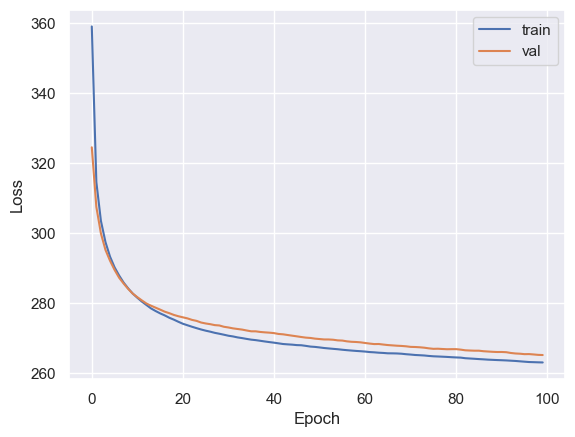

Model accuracy: 0.252


In [357]:
from sklearn.model_selection import train_test_split
num_epochs = 100
learn_rate = 0.0005
batch_size = 100
num_classes = 52
num_features = 10
X_train, X_test, y_train, y_test = train_test_split(x, genres, test_size=0.2, random_state=random_seed)
model = MLP(num_features, num_classes)
criterion = CrossEntropyCriterion(num_classes)
num_samples = int(1e3)
train_data = X_train
train_labels = y_train
val_data = X_test
val_labels = y_test
train_model(num_epochs, learn_rate, batch_size, model, criterion, train_data, train_labels, val_data, val_labels)
model_accuracy = evaluate_model(model, val_data, val_labels, batch_size, num_samples)
print('Model accuracy:', model_accuracy)

Training epoch: 10
Training epoch: 20
Training epoch: 30
Training epoch: 40
Training epoch: 50
Training epoch: 60
Training epoch: 70
Training epoch: 80
Training epoch: 90
Training epoch: 100


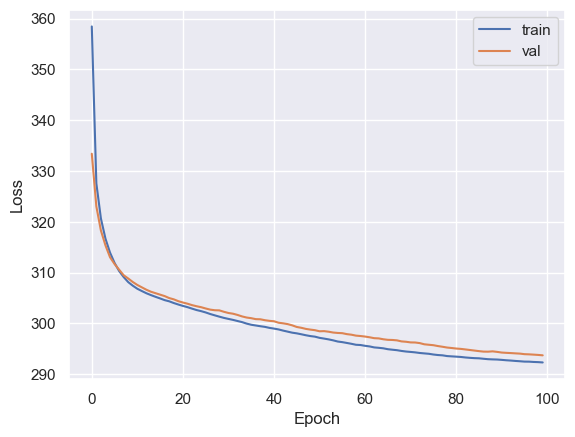

Model accuracy: 0.182


In [359]:
num_epochs = 100
learn_rate = 0.0005
batch_size = 100
num_classes = 52
num_features = 5
X_train, X_test, y_train, y_test = train_test_split(transformed, genres, test_size=0.2, random_state=random_seed)
model = MLP(num_features, num_classes)
criterion = CrossEntropyCriterion(num_classes)
num_samples = int(1e3)
train_data = X_train
train_labels = y_train
val_data = X_test
val_labels = y_test
train_model(num_epochs, learn_rate, batch_size, model, criterion, train_data, train_labels, val_data, val_labels)
model_accuracy = evaluate_model(model, val_data, val_labels, batch_size, num_samples)
print('Model accuracy:', model_accuracy)

### Extra Credit: Death metal and Children are two genres with great differences. The former is known for harshness, while the latter is known for harmony. We want to investigate whether the beats per measure differ between death metal and children music.

In [439]:
dealth_metal_df = df1[df1['track_genre']=='death-metal']
children_df = df1[df1['track_genre']=='children']

In [442]:
beats_death = np.asarray(dealth_metal_df['time_signature'])
beats_children = np.asarray(children_df['time_signature'])

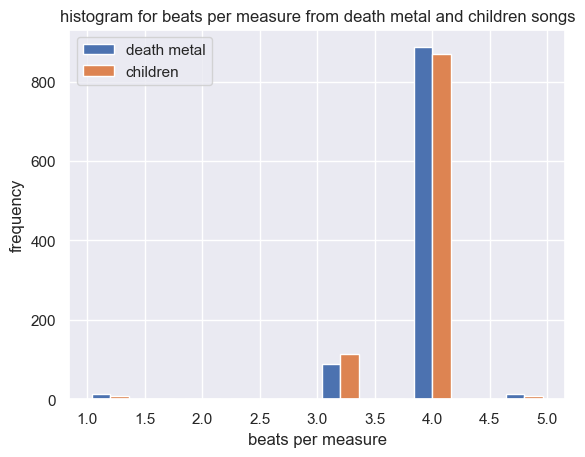

In [450]:
f, ax = plt.subplots()
ax.hist([beats_death,beats_children],label = ['death metal','children'])
ax.set_title("histogram for beats per measure from death metal and children songs")
ax.set_xlabel("beats per measure")
ax.set_ylabel("frequency")
ax.legend()

In [451]:
from scipy.stats import mannwhitneyu
mannwhitneyu(beats_death,beats_children)

MannwhitneyuResult(statistic=511783.0, pvalue=0.10728183535841923)